In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
from tqdm import tqdm

ModuleNotFoundError: No module named 'tqdm'

In [13]:
X = plt.imread('./ruler.512.tiff')

In [15]:
X = np.clip(X, 0, 1)
X = np.where(X==0, -1, 1)

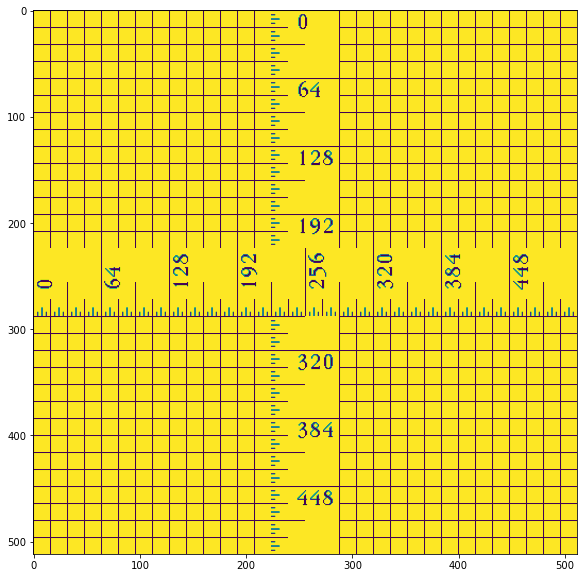

In [16]:
plt.figure(figsize=(15, 10))
plt.imshow(X,cmap="gray")
plt.show()

In [17]:
X

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1,  1,  1, ...,  1,  1,  1],
       [-1,  1,  1, ...,  1,  1,  1],
       ...,
       [-1,  1,  1, ...,  1,  1,  1],
       [-1,  1,  1, ...,  1,  1,  1],
       [-1,  1,  1, ...,  1,  1,  1]])

In [18]:
# Create a noisy version
nu = 0.10

def choose_pixels_and_add_noise(X, nu=0.2):
    """ Applies masking noise to the input data, by randomly choosing a fraction 
    'nu' of input features and setting their intensity values to zero. The rest
    of the pixels are unaffected.
    ----
    Args:

    - X: Input image of dimension (batch_size, no. of input dimensions)
    - nu: Degree of degradation chosen as a real value between [0,1]

    Returns:
    - X_noisy: Noisy version of the input image with values removed 
    """
    if len(X.shape) != 2:
        X = X.view(X.shape[0], -1)
    
    D = X.shape[1] # Getting the number of input dimensions
    num_samples_noisy = int(nu * D) # No. of randomly chosen samples to be set to zero
    X_noisy = np.copy(X)

    for i in range(X_noisy.shape[0]):

        mask = np.random.choice(X.shape[1], num_samples_noisy, replace=False)
        X_noisy[i, mask] = -1 # Setting those randomly chosen values to zero

    return X_noisy

In [19]:
X_noisy = choose_pixels_and_add_noise(X, nu=nu)

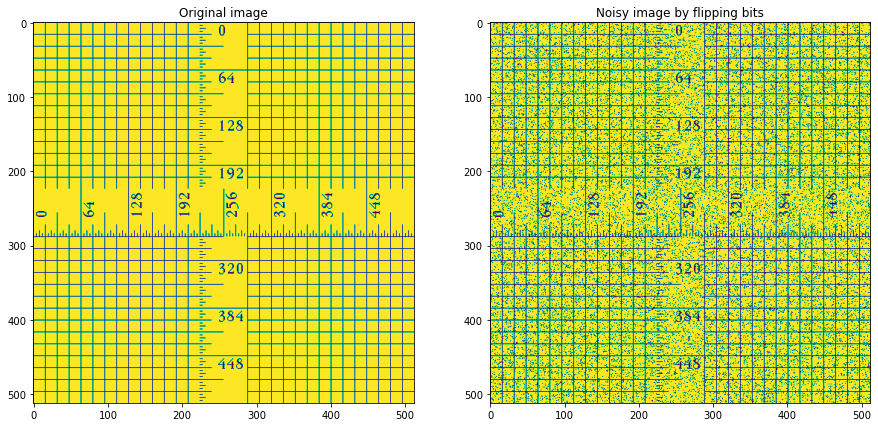

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.title("Original image")
plt.imshow(X)
plt.subplot(122)
plt.title("Noisy image by flipping bits")
plt.imshow(X_noisy)
plt.show()

In [21]:
# Designing ICM

def get_XClique(X, i, j):
    
    clique_idx = [[i + k, j + l] for (k,l) in [[-1,0],[1,0],[0,1],[0,-1]] if ((i + k >= 0 and j + l >= 0) and (i + k < X.shape[0] and j + l < X.shape[1]))]
    #print("Clique indices for X[{}, {}] are : {}".format(i, j, clique_idx))
    return clique_idx

def get_XCBook(X):
    
    XCBook = []
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            idx_clique = get_XClique(X, i, j)
            XCBook.append(idx_clique)
            
    return XCBook

def calculate_energy(X, Y, m, n, XCBook, beta, eta, h, X_label=1):
    
    X_hypothesis = np.copy(X)
    X_hypothesis[m, n] = X_label
    
    #E_X = 0
    E_XXC = 0
    #E_XYC = 0
    
    XC = np.zeros_like(X_hypothesis)
    XC = np.zeros_like(X_hypothesis)
    
    XC[:-1, :] = X_hypothesis[1:, :]  # down
    XC[1:, :] += X_hypothesis[:-1, :]  # up
    XC[:, :-1] += X_hypothesis[:, 1:]  # right
    XC[:, 1:] += X_hypothesis[:, :-1]  # left
    E_XXC = -beta*np.sum(np.multiply(X_hypothesis, XC))
    E_X = h*np.sum(X_hypothesis)
    E_XYC = -eta*np.sum(np.multiply(X_hypothesis,Y))
    
    #for count in range(len(XCBook)):
    #    idx_clique = XCBook[count]
    #    X_clique = np.array([X_hypothesis[ic, jc] for (ic,jc) in idx_clique if (ic >= 0 and jc >= 0)])
    #    E_XXC += -beta * 0.5*(np.sum(np.outer(X_clique, X_clique)) - np.sum(X_clique**2))
    
    E_total = E_X + E_XXC + E_XYC
    return E_total

def run_ICM(Y, beta, eta, h):
    
    X_reconstruct = np.copy(Y)
    XCBook = get_XCBook(Y)
    img_list = []
    #plt.figure(figsize=(15, 10))
    for i in tqdm(range(X.shape[0])):
        for j in range(X.shape[1]):
            
            start = time.time()
            E_h0 = calculate_energy(X_reconstruct, Y, i, j, XCBook, beta, eta, h, X_label=-1)
            E_h1 = calculate_energy(X_reconstruct, Y, i, j, XCBook, beta, eta, h, X_label=1)
            
            if E_h0 < E_h1:
                X_reconstruct[i, j] = -1
            else:
                X_reconstruct[i, j] = 1
            
            end = time.time()
            telapsed = end - start
            #plt.show()
            #if Y[i,j] != X_reconstruct[i, j]:
            #    print("Bit flipped at {}!".format((i,j)))
            #else:
            #    continue
        #plt.imshow(X_reconstruct)
        #plt.pause(0.001)
        img_list.append(X_reconstruct)
        #print("Processing index: {},{}, E_h0: {:.2f}, E_h1: {:.2f}, old_x: {}, new_x: {}, time_elapsed: {} s".format(i,j,E_h0,E_h1,Y[i,j],X_reconstruct[i, j], telapsed))
            
    return X_reconstruct, img_list

In [22]:
X_reconstruct, img_list = run_ICM(Y=X_noisy, beta=1.0, eta=2.1, h=0)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [12:48<00:00,  1.50s/it]


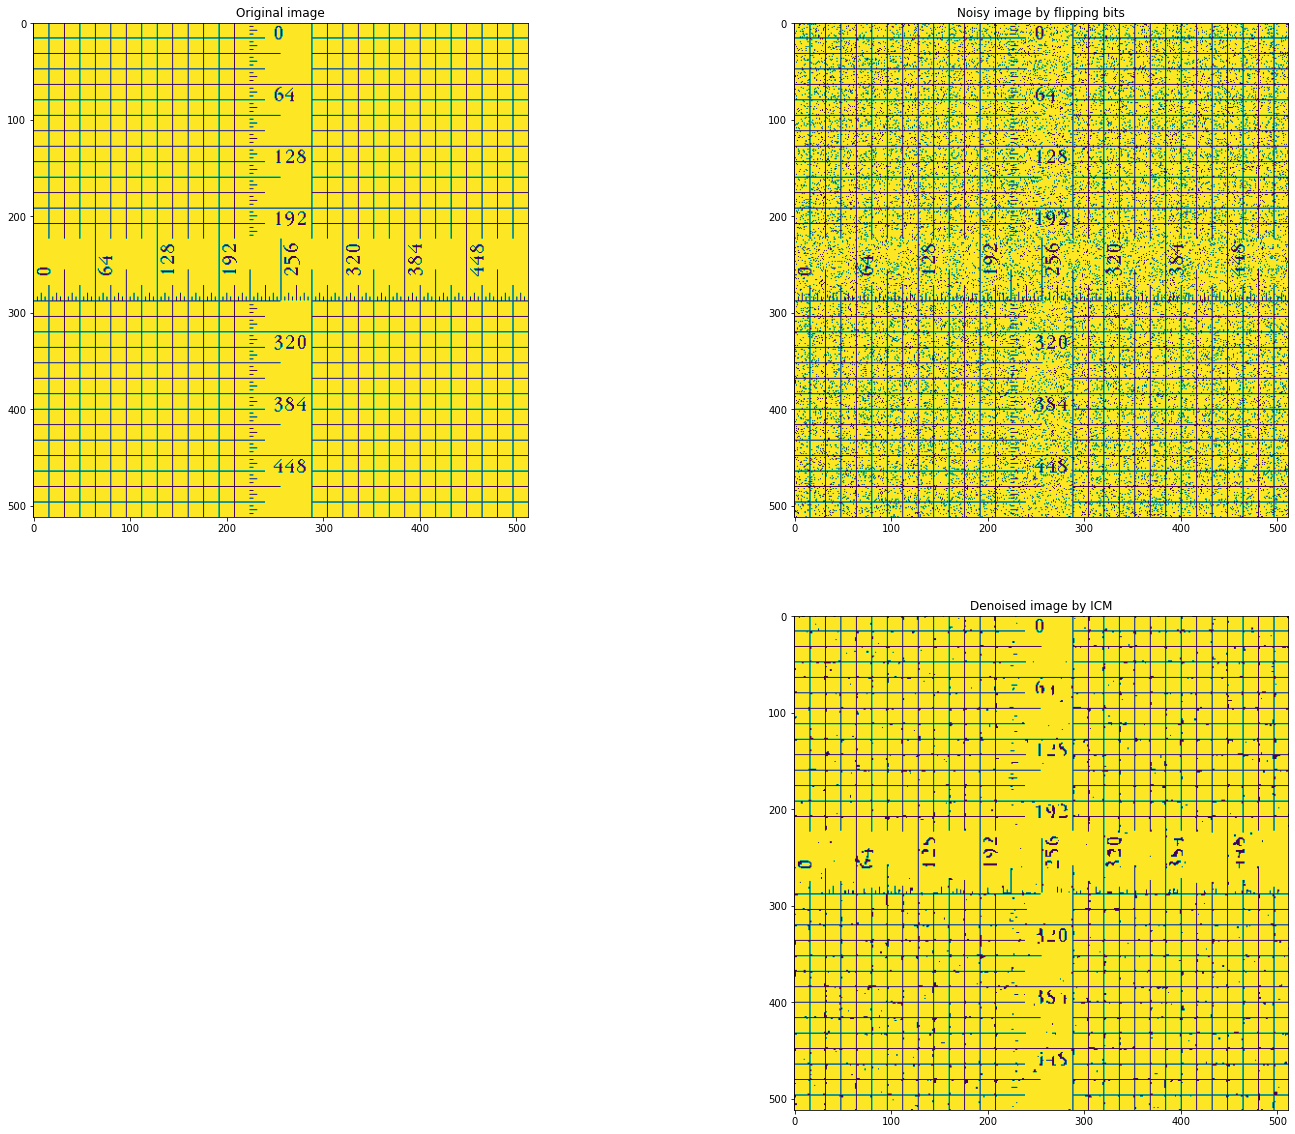

In [33]:
plt.figure(figsize=(25,20))
plt.subplot(221)
plt.title("Original image")
plt.imshow(X)
plt.subplot(222)
plt.title("Noisy image by flipping bits")
plt.imshow(X_noisy)
plt.subplot(224)
plt.title("Denoised image by ICM")
plt.imshow(X_reconstruct)
plt.show()